# WallStreetBests: Reddit Sentiment $\implies$ Stock Alpha

In [65]:
import pandas as pd
import numpy as np

import ast # Used to convert the list representation to an actual list

# Adjust path in order to access preprocessing code
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)
import src.preprocess as preprocess

## 1: Quick data audit

In [59]:
# Read in Reddit data as pd.DataFrame
reddit = (pd.read_csv('../data/reddit_wsb_with_sentiment.csv')
          .drop(['Unnamed: 0.1', 'Unnamed: 0'],
                axis=1,
                errors='ignore'))
reddit['ticker'] = reddit['ticker'].apply(ast.literal_eval)
reddit.head()

,title,score,id,url,comms_num,created,body,timestamp,raw_text,ticker,sentiment
0,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47,1.611862e+09,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35,Exit the system The CEO of NASDAQ pushed to ha...,"[CEO, GME]",-0.062377
1,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74,1.611862e+09,NaN,2021-01-28 21:28:57,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,"[NEW, FOR, GME, CAN]",-0.008729
2,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156,1.611862e+09,NaN,2021-01-28 21:26:56,"Not to distract from GME, just thought our AMC...","[GME, AMC]",0.085851
3,SHORT STOCK DOESN'T HAVE AN EXPIRATION DATE,317,l6uf6d,https://www.reddit.com/r/wallstreetbets/commen...,53,1.611862e+09,Hedgefund whales are spreading disinfo saying ...,2021-01-28 21:26:27,SHORT STOCK DOESN'T HAVE AN EXPIRATION DATE He...,"[AN, GME, ITM, DON, DON, BE]",-0.150121
4,THIS IS THE MOMENT,405,l6ub9l,https://www.reddit.com/r/wallstreetbets/commen...,178,1.611862e+09,Life isn't fair. My mother always told me that...,2021-01-28 21:19:31,THIS IS THE MOMENT Life isn't fair. My mother ...,"[ARE, GME, BB]",-0.128038


### 1a: Null counts per column

In [60]:
# For each column
null_counts = pd.DataFrame(columns=['column_name', 'null_count'])
for col in reddit.columns:
    # Count returns the number of non null values in an object
    current = pd.DataFrame({'column_name' : [col], 'null_count' : [reddit[col].count()]})
    null_counts = pd.concat([null_counts, current])
null_counts

,column_name,null_count
0,title,28909
0,score,28909
0,id,28909
0,url,28909
0,comms_num,28909
0,created,28909
0,body,18008
0,timestamp,28909
0,raw_text,28909
0,ticker,28909


### 1b: Top-10 tickers by post count and by up-vote score.

In [61]:
# Copies each row for each ticker it contains information about
reddit_exploded = reddit.explode('ticker')
ticker_stats = reddit_exploded.groupby('ticker').agg({
    'score' : ['count', 'sum'] # Score maps to these two functions
}).round(2)

# Flatten column names- otherwise there is a row before called 'score'
ticker_stats.columns = ['post_count', 'cum_score']
ticker_stats = ticker_stats.reset_index() # Otherwise, ticker is the index, we want as column

print('Top 10 Tickers by Post Count')
print(ticker_stats.sort_values('post_count', ascending=False).head(10))

print()

print('Top 10 Tickers by Aggregate Score')
print(ticker_stats.sort_values('cum_score', ascending=False).head(10))

Top 10 Tickers by Post Count
     ticker  post_count  cum_score
926     GME       23682   46155124
86      AMC        7902    6287943
1022   HOLD        3682    2731854
196      BB        3142    1788179
297     BUY        2466    1429137
1508    NOK        2233     822555
1796     RH        2211    1936715
837     FOR        1838    1626893
361     CEO        1747    1635297
734      EV        1516     444604

Top 10 Tickers by Aggregate Score
     ticker  post_count  cum_score
926     GME       23682   46155124
86      AMC        7902    6287943
658    EDIT        1101    3068151
1022   HOLD        3682    2731854
1146     IT        1295    2130008
1796     RH        2211    1936715
1957    SLV         585    1878881
196      BB        3142    1788179
1150    ITM         751    1684780
361     CEO        1747    1635297


## 2: Daily sentiment feature

### 2a: Use VADER (or FinBERT for finance-tuned) to score each post

Text(0.5, 1.0, 'Distribution of Sentiment Scores Across Posts')

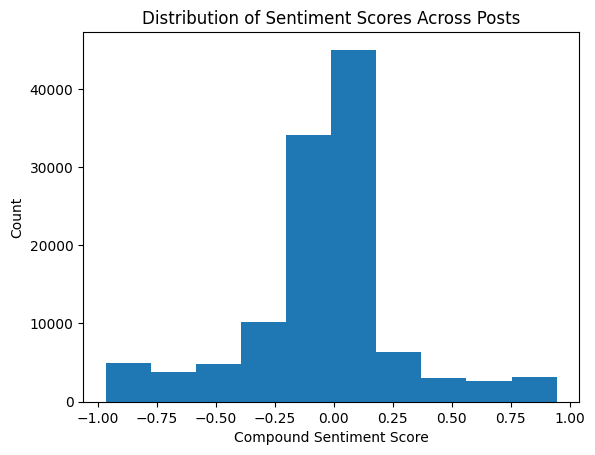

In [62]:
import matplotlib.pyplot as plt

# Distribution of posts
plt.hist(reddit_exploded['sentiment'])
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Count')
plt.title('Distribution of Sentiment Scores Across Posts')

### 2b: Aggregate to sent_mean, sent_median, bull_ratio by ticker-date.

In [70]:
def classify_bull_bear(compound_score):
    '''
    Classifies a post as either bullish or bearish by
    predetermined thresholds on the sentiment score.
    Parameters:
    compound_score (float): the compound sentiment score of the post to be classified
    Returns:
    str (bullish, bearish, neutral): the output label
    '''
    if compound_score >= .05:
        return 'bullish'
    elif compound_score <= -.05:
        return 'bearish'
    else:
        return 'neutral'

def bull_ratio(series):
    '''
    Computes the bull ratio for a group of tickers in a pd.DataFrame.
    Parameters:
    group (pd.Series): a series containing 'bull'/'bear' sentiment classificaitons
    Returns:
    float: bull ratio = #bullish/(#bullish + #bearish)
    '''
    bull_count = (series == 'bullish').sum()
    bear_count = (series == 'bearish').sum()
    total = bull_count + bear_count
    return bull_count / total if total > 0 else np.nan # Gracefully handle zero case

In [71]:
# Create a column to only store date
reddit_exploded['date'] = pd.to_datetime(reddit_sent['timestamp'])
reddit_exploded['date'] = reddit_exploded['date'].dt.date
reddit_exploded['bull_bear'] = reddit_exploded['sentiment'].apply(classify_bull_bear)

date_stats = reddit_exploded.groupby(['date', 'ticker']).agg(
    sent_mean=('sentiment', 'mean'),
    sent_median=('sentiment', 'median'),
    bull_ratio=('bull_bear', bull_ratio)
)

date_stats = date_stats.reset_index()
date_stats

,date,ticker,sent_mean,sent_median,bull_ratio
0,2020-09-29,CBAT,0.635384,0.635384,1.0
1,2020-09-29,ES,0.635384,0.635384,1.0
2,2020-09-29,EV,0.635384,0.635384,1.0
3,2020-09-29,OXBR,0.635384,0.635384,1.0
4,2020-09-29,SPI,0.635384,0.635384,1.0
...,...,...,...,...,...
20509,2021-08-16,PT,0.374970,0.374970,1.0
20510,2021-08-16,SEE,0.194275,0.194275,1.0
20511,2021-08-16,TGT,0.013615,0.013615,NaN
20512,2021-08-16,VZ,0.762364,0.762364,1.0


Text(0.5, 1.0, 'Distribution of Bull Ratios')

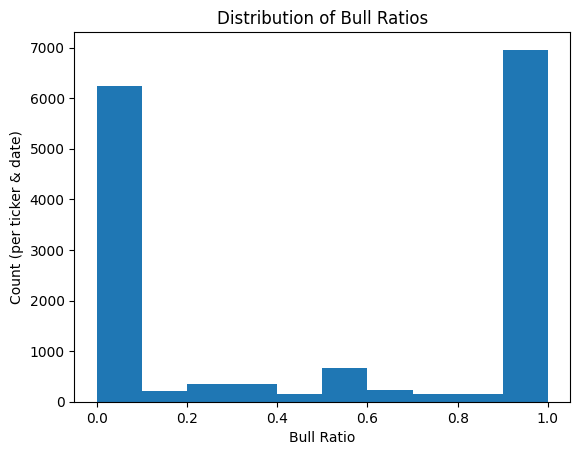

In [ ]:
# Plot all bull ratios that are not NA
plt.hist(date_stats['bull_ratio'].dropna())
plt.xlabel('Bull Ratio')
plt.ylabel('Count (per ticker & date)')
plt.title('Distribution of Bull Ratios')

## 3: Merge with daily returns

### 3a: Pull close-to-close log-return from Kaggle dataset